In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from pprint import pprint
from collections import namedtuple

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams["image.origin"] = 'lower'

In [2]:
data_folder = "/eos/user/d/dvalsecc/www/ECAL/Transparency/data_v1"

In [3]:
data_EE = np.load(f"{data_folder}/transp_data_EE.npy", mmap_mode="r")
data_EB = np.load(f"{data_folder}/transp_data_EB.npy", mmap_mode="r")

## Read brilcalc metadata

In [4]:
meta = pd.read_csv("transp_metadata_2017_v2.csv",sep=",").astype({"transp_entry":"int64", "time": "int64", "fill_num":"int64", "time_in_fill":"int64", "time_in_fill_stable":"int64"})
bril = pd.read_csv("lumi_brilcalc_2017.csv", sep=",", comment="#")
bril["run"] = bril.apply(lambda row: int(row["run:fill"].split(":")[0]), axis=1)
bril["fill"] = bril.apply(lambda row: int(row["run:fill"].split(":")[1]), axis=1)

In [8]:
print(meta.columns)
print(bril.columns)

Index(['transp_entry', 'time', 'bfield', 'fill_num', 'fill_time_start',
       'fill_time_stable_start', 'time_in_fill', 'time_in_fill_stable',
       'run_in_fill', 'in_fill'],
      dtype='object')
Index(['run:fill', 'ls', 'time', 'beamstatus', 'E(GeV)', 'delivered(/ub)',
       'recorded(/ub)', 'avgpu', 'source', 'run', 'fill'],
      dtype='object')


## Starting lumisection

In [9]:
def gettimes(timestamp, n, t=23):
    o = []
    for i in range(abs(n)):
            o.append(timestamp + i*t)
    if n >0:
        return o
    else:
        o.reverse()
        return o


Look for the biggest deltaT between measurements

In [10]:
meta["time-1"] = meta["time"].shift(1)
meta["deltaT"] = (meta["time"]- meta["time-1"])

Cumulative luminosity over fill

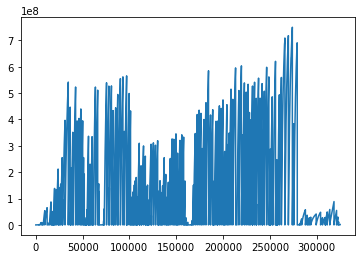

In [11]:
plt.plot(bril.groupby("fill")["delivered(/ub)"].cumsum())

## Cumulative lumi in fill estimation
Let's calculate cumulative lumi in the fill, and cumulative time in the fill thanks to pandas groupby and transform

In [12]:
bril.head()

,run:fill,ls,time,beamstatus,E(GeV),delivered(/ub),recorded(/ub),avgpu,source,run,fill
0,294904:5697,57:0,1495541393,FLAT TOP,6500,0.125840,0.0,0.0,PLTZERO,294904,5697
1,294904:5697,58:0,1495541413,FLAT TOP,6500,0.126789,0.0,0.5,PLTZERO,294904,5697
2,294904:5697,59:0,1495541436,FLAT TOP,6500,0.122161,0.0,0.5,PLTZERO,294904,5697
3,294904:5697,60:0,1495541460,FLAT TOP,6500,0.118824,0.0,0.7,PLTZERO,294904,5697
4,294926:5698,25:0,1495548553,FLAT TOP,6500,0.138309,0.0,0.0,PLTZERO,294926,5698


In [13]:
bril["lumi_in_fill"] = bril.groupby("fill")["delivered(/ub)"].cumsum()
bril["time_in_fill"] = bril.groupby("fill")["time"].transform(lambda t: t - t.min())
bril["time_in_fill_stable"] = bril[bril.beamstatus=="STABLE BEAMS"].groupby("fill")["time"].transform(lambda t: t - t.min())
bril["time_in_fill_stable"] = bril["time_in_fill_stable"].fillna(0)

In [14]:
bril.head()

,run:fill,ls,time,beamstatus,E(GeV),delivered(/ub),recorded(/ub),avgpu,source,run,fill,lumi_in_fill,time_in_fill,time_in_fill_stable
0,294904:5697,57:0,1495541393,FLAT TOP,6500,0.125840,0.0,0.0,PLTZERO,294904,5697,0.125840,0,0.0
1,294904:5697,58:0,1495541413,FLAT TOP,6500,0.126789,0.0,0.5,PLTZERO,294904,5697,0.252629,20,0.0
2,294904:5697,59:0,1495541436,FLAT TOP,6500,0.122161,0.0,0.5,PLTZERO,294904,5697,0.374790,43,0.0
3,294904:5697,60:0,1495541460,FLAT TOP,6500,0.118824,0.0,0.7,PLTZERO,294904,5697,0.493614,67,0.0
4,294926:5698,25:0,1495548553,FLAT TOP,6500,0.138309,0.0,0.0,PLTZERO,294926,5698,0.138309,0,0.0


## Utility functions to query bril information later


In [15]:
# Useful Namestupls with fill information
fillinfo = namedtuple("fillinfo", ["fill", "beamstatus", "lumi_inst", "lumi_in_fill", "time_in_fill", "time_in_fill_stable"])

In [18]:
def is_in_fill(timestamp):
    a = bril[abs(bril.time - timestamp)<23]
    if len(a):
        a = a.iloc[0]
        return fillinfo(a.fill, a.beamstatus, a["delivered(/ub)"], a.lumi_in_fill, a.time_in_fill, a.time_in_fill_stable)
    else:
        return fillinfo(0, "NOBEAM", 0, 0,0,0)
    
#is_in_fill(starting_time)

In [19]:
def get_lumi_interval(timestart, timestop):
    return bril[ (bril.time >= timestart) & (bril.time <= timestop)]["delivered(/ub)"].sum()

#get_lumi_interval(starting_time, 1512022951 )

In [20]:
def get_last_fill_end(timestamp, fill=0):
    df = bril[(bril.time <=timestamp) & (bril.fill != fill)]
    if not df.empty:
        return df.iloc[-1]
    else: 
        return pd.DataFrame()

In [21]:
def get_fill_timeinterval(fill):
    t = bril[bril.fill== fill].time
    return t.iloc[0], t.iloc[-1]

In [23]:
get_fill_timeinterval(6417)

(1511659746, 1511692258)

## Lumi/fill metadata output
Let's read bril data to create metadata points every N minutes

In [24]:
outputs = {
    "in_fill" : [],
    "time": [],
    "lumi_inst": [],
    "lumi_in_fill": [],
    "lumi_since_last_point": [],
    "lumi_last_fill": [],
    "fill_num": [],
    "time_in_fill": [],
    "time_in_fill_stable": [],
    "time_from_last_fill" : [],
    "last_dump_duration" : [],
    "last_fill_duration": [],
}


def add_output(out):
    for k, v in out.items():
        outputs[k].append(v)


In [26]:
# Interpolation time
time_interval = 600

In [25]:
previous_time = bril.time.iloc[0]
tot = (bril.time.iloc[-1]-bril.time.iloc[0])//time_interval

for iev, curr_time in enumerate(range(bril.time.iloc[0], bril.time.iloc[-1], time_interval)):
    if iev % 100 == 0:
        print(f"{iev}/{tot}")
    
    fill_info = is_in_fill(curr_time)
    
    last_fill_info = get_last_fill_end(curr_time, fill_info.fill)
    
    if last_fill_info.empty:
        last_fill_end = curr_time
        last_fill_duration = 0
        last_dump_duration = 0
        lumi_last_fill = 0
    else:
        last_fill_end = last_fill_info.time
        last_fill_duration = last_fill_info.time_in_fill
        lumi_last_fill = last_fill_info.lumi_in_fill
        
        if fill_info.fill != 0:
            last_dump_duration =  (curr_time - fill_info.time_in_fill) - last_fill_info.time 
        else:
            last_dump_duration = curr_time - last_fill_info.time 
    
    time_from_last_fill = curr_time - last_fill_end
    lumi_since_last_point = get_lumi_interval(previous_time,curr_time)
    
    out = {
        "in_fill": int(fill_info.fill != 0),
        "time": curr_time,
        "fill_num": fill_info.fill,
        "lumi_inst": fill_info.lumi_inst,
        "lumi_in_fill": fill_info.lumi_in_fill,
        "lumi_since_last_point": lumi_since_last_point,
        "lumi_last_fill": lumi_last_fill,
        
        "time_in_fill": fill_info.time_in_fill,
        "time_in_fill_stable":  fill_info.time_in_fill_stable,
        "time_from_last_fill": time_from_last_fill, 
        "last_dump_duration": last_dump_duration, 
        "last_fill_duration": last_fill_duration
    }
    
    previous_time = curr_time
    add_output(out)



0/27469
100/27469
200/27469
300/27469
400/27469
500/27469
600/27469
700/27469
800/27469
900/27469
1000/27469
1100/27469
1200/27469
1300/27469
1400/27469
1500/27469
1600/27469
1700/27469
1800/27469
1900/27469
2000/27469
2100/27469
2200/27469
2300/27469
2400/27469
2500/27469
2600/27469
2700/27469
2800/27469
2900/27469
3000/27469
3100/27469
3200/27469
3300/27469
3400/27469
3500/27469
3600/27469
3700/27469
3800/27469
3900/27469
4000/27469
4100/27469
4200/27469
4300/27469
4400/27469
4500/27469
4600/27469
4700/27469
4800/27469
4900/27469
5000/27469
5100/27469
5200/27469
5300/27469
5400/27469
5500/27469
5600/27469
5700/27469
5800/27469
5900/27469
6000/27469
6100/27469
6200/27469
6300/27469
6400/27469
6500/27469
6600/27469
6700/27469
6800/27469
6900/27469
7000/27469
7100/27469
7200/27469
7300/27469
7400/27469
7500/27469
7600/27469
7700/27469
7800/27469
7900/27469
8000/27469
8100/27469
8200/27469
8300/27469
8400/27469
8500/27469
8600/27469
8700/27469
8800/27469
8900/27469
9000/27469
9100/27469


In [27]:
output_df = pd.DataFrame(outputs)
output_df.to_csv("output_metadata_2017_10min.csv")

## Transparency data interpolation


In [33]:
timesteps_df = pd.read_csv("output_metadata_2017_10min.csv", sep=",", comment="#")

In [34]:
def get_transp_EB(index):
    EB = data_EB[int(index)-1]
    return EB

def get_transp_EE(index):
    EE = data_EE[int(index)-1]
    return EE

def get_transp_interval(timestamp):
    last_meas = meta[(meta.time < timestamp)].iloc[-1]
    next_meas = meta[(meta.time > timestamp)]
    if next_meas.empty:
        return last_meas, pd.DataFrame()
    #print("{} {} | {}| x0: {} | Interval diff {:.3f}".format(last_meas.time, next_meas.time,  timestamp,timestamp- last_meas.time, ( next_meas.time - last_meas.time) / 60))
    return last_meas, next_meas.iloc[0]


def interpolate_transp(x, x0, x1, y0, y1):
    z = (x - x0)*( (y1-y0)/(x1-x0)) + y0
    #print(f"x {x}, x0 {x0}, x1 {x1}, y0 {y0}, y1 {y1} ---> {z}")
    return z



def get_transp_interpolate(timestamp):
    Z0, Z1 = get_transp_interval(timestamp)
    if Z1.empty:
        return np.array([]), np.array([])
    transp_EB_y0 = get_transp_EB(Z0.transp_entry)
    transp_EB_y1 = get_transp_EB(Z1.transp_entry)
    trans_EB = interpolate_transp(timestamp, Z0.time, Z1.time,  transp_EB_y0, transp_EB_y1)
    
    transp_EE_y0 = get_transp_EE(Z0.transp_entry)
    transp_EE_y1 = get_transp_EE(Z1.transp_entry)
    trans_EE =  interpolate_transp(timestamp,  Z0.time, Z1.time,  transp_EE_y0, transp_EE_y1)
    return trans_EB, trans_EE


In [ ]:
transp_EB_output = []
transp_EE_output = []


tot = len(timesteps_df)

for iev, row in timesteps_df.iterrows():
    if iev % 100 == 0:
        print(f"{iev}/{tot}")
    
    tEB, tEE = get_transp_interpolate(row.time)
    
    if tEB.size == 0 or tEE.size == 0:
        break
    transp_EB_output.append(tEB)
    transp_EE_output.append(tEE)



np.save("output_transp_EB_ix1_10min.npy",  np.array(transp_EB_output))
np.save("output_transp_EE_ix1_10min.npy",  np.array(transp_EE_output))

0/27470
100/27470
200/27470
300/27470
400/27470
500/27470
600/27470
700/27470
800/27470
900/27470
1000/27470
1100/27470
1200/27470
1300/27470
1400/27470
1500/27470
1600/27470
1700/27470
1800/27470
1900/27470
2000/27470
2100/27470
2200/27470
2300/27470
2400/27470
2500/27470
2600/27470
2700/27470
2800/27470
2900/27470
3000/27470
3100/27470
3200/27470
3300/27470
3400/27470
3500/27470
3600/27470
3700/27470
3800/27470
3900/27470
4000/27470
4100/27470
4200/27470
4300/27470
4400/27470
4500/27470
4600/27470
4700/27470
4800/27470
4900/27470
5000/27470
5100/27470
5200/27470
5300/27470
5400/27470
5500/27470
5600/27470
5700/27470
5800/27470
5900/27470
6000/27470
6100/27470
6200/27470
6300/27470
6400/27470
6500/27470
6600/27470
6700/27470
6800/27470
6900/27470
7000/27470
7100/27470
7200/27470
7300/27470
7400/27470
7500/27470
7600/27470
7700/27470
7800/27470
7900/27470
8000/27470
8100/27470
8200/27470
8300/27470
8400/27470
8500/27470
8600/27470
8700/27470
8800/27470
8900/27470
9000/27470
9100/27470
